In [311]:
import math
from typing import Any
from datetime import datetime
from contextlib import contextmanager
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from cleverminer import cleverminer
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import plot_tree
from sklearn.metrics import accuracy_score

In [115]:
# SQL Database helpers

db = sqlite3.connect('Database') if not 'db' in locals() else db

def dict_factory(cursor, row):
    d = {}
    for idx, col in enumerate(cursor.description):
        d[col[0]] = row[idx]
    return d
    
db.row_factory = dict_factory

@contextmanager
def cursor():
    cursor_ = None
    try:
        cursor_ = db.cursor()
        yield cursor_
    finally:
        if cursor_:
            cursor_.close()


def table_exists(table_name: str) -> bool:
    with cursor() as c:
        try:
            c.execute(f'SELECT 1 FROM "{table_name}"')
            return True
        except sqlite3.OperationalError:
            return False


In [116]:
electricity = pd.read_csv('data/electricity.csv') \
    if 'electricity' not in locals() else electricity

daily_weather = pd.read_parquet('data/daily_weather.parquet') \
    if 'daily_weather' not in locals() else daily_weather

cities_in_countries = pd.read_csv('data/cities.csv') \
    if 'cities_in_countries' not in locals() else cities_in_countries

In [117]:
if not table_exists('daily_weather_raw'):
    daily_weather.to_sql('daily_weather_raw', db, if_exists='replace')
    
if not table_exists('weather_cities'): 
    cities_in_countries.to_sql('weather_cities', db, if_exists='replace')

if not table_exists('electricity'): 
    electricity.to_sql('electricity', db, if_exists='replace')

In [118]:
# grouping weather data by month - to join with electricity
with cursor() as c:
    try:
        c.execute('ALTER TABLE daily_weather_raw ADD COLUMN year INT;')
        c.execute('ALTER TABLE daily_weather_raw ADD COLUMN month INT;')
        c.execute('UPDATE daily_weather_raw SET year=strftime("%Y", date), month=strftime("%m", date);')
        c.execute('DELETE FROM daily_weather_raw WHERE year < 2010 OR year > 2018;')
    except:
        pass # už se stalo

In [119]:
# Missing values treatment:
average_temps = """
    SELECT 
        country, 
        month, 
        AVG(max_temp_c) AS max, 
        AVG(min_temp_c) AS min,
        AVG(avg_sea_level_pres_hpa) AS pressure,
        AVG(precipitation_mm) AS precipitation
    FROM daily_weather_raw
    JOIN weather_cities ON weather_cities.station_id = daily_weather_raw.station_id
    GROUP BY country, month
"""

complete_weather_query = f"""
    SELECT 
        c.country,
        w.year,
        w.month,
        w.season,
        AVG(avg_temp_c) AS avg_temp_c,
        COALESCE(MAX(max_temp_c), _avg.max) AS max_temp_c,
        COALESCE(MIN(min_temp_c), _avg.min) AS min_temp_c,
        COALESCE(AVG(avg_sea_level_pres_hpa), _avg.pressure) AS avg_sealevel_pressure_hpa,
        COALESCE(AVG(precipitation_mm), _avg.precipitation) AS avg_daily_precipitation_mm,
        AVG(sunshine_total_min) AS avg_sunshine_min,
        SUM(sunshine_total_min) AS total_sunshine_min,
        AVG(snow_depth_mm) AS avg_snow_depth_mm
    FROM daily_weather_raw w
    JOIN weather_cities c ON c.station_id = w.station_id
    LEFT JOIN ({average_temps}) _avg ON (
        _avg.country = c.country
        AND _avg.month = w.month
    )
    GROUP BY c.country, w.year, w.month
"""

with cursor() as c:
    limit = 5
    print(pd.DataFrame(c.execute(f'{complete_weather_query} LIMIT ?;', [limit]).fetchall()))

       country  year  month  season  avg_temp_c  max_temp_c  min_temp_c  \
0  Afghanistan  2010      1  Winter    4.236301        22.8       -18.0   
1  Afghanistan  2010      2  Winter    3.833871        26.7       -19.5   
2  Afghanistan  2010      3  Spring   11.642581        34.8        -6.5   
3  Afghanistan  2010      4  Spring   17.192517        34.8        -5.3   
4  Afghanistan  2010      5  Spring   20.677703        39.8         2.5   

  avg_sealevel_pressure_hpa  avg_daily_precipitation_mm avg_sunshine_min  \
0                      None                    2.134545             None   
1                      None                    4.703774             None   
2                      None                    2.781538             None   
3                      None                    3.335593             None   
4                      None                    3.452727             None   

  total_sunshine_min  avg_snow_depth_mm  
0               None         106.631579  
1       

In [120]:
# read and load population datasets

if not table_exists('population'):
    population = pd.read_csv('data/population_total_long.csv')
    population.to_sql('population', db, if_exists='replace')

if not table_exists('pop_female_perc'):
    pop_female_perc = pd.read_csv('data/population_female_percentage_long.csv')
    pop_female_perc.to_sql('pop_female_perc', db, if_exists='replace')

if not table_exists('pop_density'):
    pop_density = pd.read_csv('data/population_density_long.csv')
    pop_density.to_sql('pop_density', db, if_exists='replace')

if not table_exists('pop_below_14'):
    pop_below_14 = pd.read_csv('data/population_below_age_14_percentage_long.csv')
    pop_below_14.to_sql('pop_below_14', db, if_exists='replace')

if not table_exists('pop_above_65'):
    pop_above_65 = pd.read_csv('data/population_above_age_65_percentage_long.csv')
    pop_above_65.to_sql('pop_above_65', db, if_exists='replace')

In [121]:
# Odvozené sloupce: male_perc, population_working_age

population_complete = """
    SELECT 
        p."Country Name" AS country, 
        p.Year AS year,
        female.Count AS female_perc,
        (100 - female.Count) AS male_perc,
        density.Count AS population_density,
        below14.Count AS population_below_14_perc,
        above65.Count AS population_above_65_perc,
        (100 - below14.Count - above65.Count) AS population_working_age_perc
    FROM population p
    JOIN pop_female_perc female ON (
        female."Country Name" = p."Country Name" AND female.Year = p.Year
    )
    JOIN pop_density density ON (
        density."Country Name" = p."Country Name" AND density.Year = p.Year
    )
    JOIN pop_below_14 below14 ON (
        below14."Country Name" = p."Country Name" AND below14.Year = p.Year
    )
    JOIN pop_above_65 above65 ON (
        above65."Country Name" = p."Country Name" AND above65.Year = p.Year
    )
"""

with cursor() as c:
    limit = 5
    print(pd.DataFrame(c.execute(f'{population_complete} LIMIT ?;', [limit]).fetchall()))

                country  year  female_perc  male_perc  population_density  \
0                 Aruba  1961           50         50                 307   
1           Afghanistan  1961           48         52                  14   
2                Angola  1961           49         51                   4   
3               Albania  1961           48         52                  60   
4  United Arab Emirates  1961           48         52                   1   

   population_below_14_perc  population_above_65_perc  \
0                        43                         2   
1                        42                         2   
2                        42                         3   
3                        40                         5   
4                        43                         3   

   population_working_age_perc  
0                           55  
1                           56  
2                           55  
3                           55  
4                           5

In [357]:
def select_product(product: str|list[str]) -> tuple[str, list]:
    if type(product) == str:
        product = [product]

    placeholders = ', '.join(['?' for _ in range(len(product))])

    return (f"""
        SELECT
            (e.COUNTRY || "-" || e.YEAR || "-" || e.MONTH) AS key,
            e.COUNTRY,
            e.YEAR,
            e.MONTH,
            COALESCE(SUM(e.VALUE), 0) AS value
        FROM electricity e 
        WHERE e.PRODUCT IN ({placeholders})
        GROUP BY e.COUNTRY, e.YEAR, e.MONTH
    """, product)
    
def group_by_year(data: list[dict]) -> dict[int, Any]:
    by_year = {}
    for row in data:
        key = row['year']
        if key not in by_year:
            by_year[key] = []
        by_year[row['year']].append(row['value'])

    return by_year

In [358]:
# Jsou sloupce s názvy "Total ..., renewables, ..." agregace, nebo je některé země uvádějí pouze agregace 
# místo konkrétních zdrojů el. energie?

with cursor() as c:
    # "Total combustible fuels" je agregace - nebereme v potaz
    print('Total combustible fuels', c.execute("""
        SELECT COUNTRY, COUNT(*) 
        FROM electricity 
        WHERE PRODUCT IN ("Total combustible fuels", "Coal") 
        GROUP BY COUNTRY, YEAR, MONTH 
        HAVING COUNT(*) > 1
        LIMIT 5
    """).fetchall())

    # "Non renewables" není
    print('Non renewables', c.execute("""
        SELECT COUNTRY, COUNT(*) 
        FROM electricity 
        WHERE PRODUCT IN ("Non renewables", "Coal")
        GROUP BY COUNTRY, YEAR, MONTH 
        HAVING COUNT(*) > 1
        LIMIT 5
    """).fetchall())

    # "Renewables" je 
    print('Renewables', c.execute("""
        SELECT COUNTRY, COUNT(*) 
        FROM electricity 
        WHERE PRODUCT IN ("Renewables", "Solar")
        GROUP BY COUNTRY, YEAR, MONTH 
        HAVING COUNT(*) > 1
        LIMIT 5
    """).fetchall())
    

Total combustible fuels [{'COUNTRY': 'Argentina', 'COUNT(*)': 2}, {'COUNTRY': 'Argentina', 'COUNT(*)': 2}, {'COUNTRY': 'Argentina', 'COUNT(*)': 2}, {'COUNTRY': 'Argentina', 'COUNT(*)': 2}, {'COUNTRY': 'Argentina', 'COUNT(*)': 2}]
Non renewables []
Renewables [{'COUNTRY': 'Argentina', 'COUNT(*)': 2}, {'COUNTRY': 'Argentina', 'COUNT(*)': 2}, {'COUNTRY': 'Argentina', 'COUNT(*)': 2}, {'COUNTRY': 'Argentina', 'COUNT(*)': 2}, {'COUNTRY': 'Argentina', 'COUNT(*)': 2}]


Vyfiltované (déle používané) hodnoty sloupce _PRODUCT_ z datasetu _electricity_

In [124]:
renewables = ['Hydro', 'Wind', 'Solar', 'Geothermal', 'Combustible renewables', 'Other renewables', 'Other combustible renewables']
non_renewables = ['Coal', 'Oil', 'Natural gas', 'Low carbon', 'Fossil fuels', 'Nuclear']

all_energy_producing_sources = [*renewables, *non_renewables]

total_q, total_p = select_product(all_energy_producing_sources)

def select_product_relative(product: str|list[str]) -> tuple[str, list]:
    product_q, product_p = select_product(product)
    parameters = [*total_p, *product_p]
    query = f"""
        SELECT 
            t.key,
            t.COUNTRY AS country,
            t.YEAR AS year,
            t.MONTH AS month,
            (p.value / t.value) AS value
        FROM ({total_q}) t
        JOIN ({product_q}) p ON t.key = p.key
    """

    return query, parameters

In [365]:
relative_coal, relative_coal_p = select_product_relative('Coal')
relative_nuclear, relative_nuclear_p = select_product_relative('Nuclear')

relative_hydro, relative_hydro_p = select_product_relative('Hydro')
relative_wind, relative_wind_p = select_product_relative('Wind')
relative_solar, relative_solar_p = select_product_relative('Solar')
relative_renewables, relative_renewables_p = select_product_relative(renewables)

parameters = [
    *relative_coal_p,
    *relative_nuclear_p,
    *relative_hydro_p,
    *relative_wind_p,
    *relative_solar_p,
    *relative_renewables_p,
]

def create_join(on_alias: str, query: str, alias: str, kind: str = 'LEFT') -> str:
    return f"""{kind} JOIN ({query}) {alias} ON (
        {alias}.country = {on_alias}.COUNTRY
        AND {alias}.year = {on_alias}.YEAR
        AND {alias}.month = {on_alias}.MONTH
    )"""

complete_data_query = f"""
    SELECT 
        e.COUNTRY AS country,
        e.YEAR AS year,
        e.MONTH AS month,
        
        COALESCE(coal.value, 0) AS coal_perc,
        COALESCE(nuclear.value, 0) AS nuclear_perc,
        
        COALESCE(hydro.value, 0) AS hydro_perc,
        COALESCE(wind.value, 0) AS wind_perc,
        COALESCE(solar.value, 0) AS solar_perc,
        COALESCE(renewables.value, 0) AS renewables_perc,
        w.*,
        pop.*
    FROM electricity e
    JOIN ({population_complete}) pop ON (
        pop.country = e.COUNTRY
        AND pop.year = e.YEAR
    )
    {create_join('e', complete_weather_query, 'w', kind='INNER')}
    
    {create_join('e', relative_coal, 'coal')}
    {create_join('e', relative_nuclear, 'nuclear')}
    
    {create_join('e', relative_hydro, 'hydro')}
    {create_join('e', relative_wind, 'wind')}
    {create_join('e', relative_solar, 'solar')}
    {create_join('e', relative_renewables, 'renewables')}
    GROUP BY e.COUNTRY, e.YEAR, e.MONTH
"""

print('complete data query: ', complete_data_query)

if table_exists('data'):
   df = pd.read_sql('SELECT * FROM data;', db)
else:
    with cursor() as c:
        df = pd.DataFrame(c.execute(f'{complete_data_query};', parameters).fetchall())
        df.to_sql('data', db)
        print('Total countries with values', len(c.execute(f'SELECT DISTINCT country FROM ({complete_data_query});', parameters).fetchall()))
        
df_orig_ = df.copy()

complete data query:  
    SELECT 
        e.COUNTRY AS country,
        e.YEAR AS year,
        e.MONTH AS month,
        
        COALESCE(coal.value, 0) AS coal_perc,
        COALESCE(nuclear.value, 0) AS nuclear_perc,
        
        COALESCE(hydro.value, 0) AS hydro_perc,
        COALESCE(wind.value, 0) AS wind_perc,
        COALESCE(solar.value, 0) AS solar_perc,
        COALESCE(renewables.value, 0) AS renewables_perc,
        w.*,
        pop.*
    FROM electricity e
    JOIN (
    SELECT 
        p."Country Name" AS country,
        p.Year AS year,
        female.Count AS female_perc,
        (100 - female.Count) AS male_perc,
        density.Count AS population_density,
        below14.Count AS population_below_14_perc,
        above65.Count AS population_above_65_perc,
        (100 - below14.Count - above65.Count) AS population_working_age_perc
    FROM population p
    JOIN pop_female_perc female ON (
        female."Country Name" = p."Country Name" AND female.Year = p.Yea

## Missing values treatment

In [363]:
# Drop pro všechny sloupce, které nemají hodnotu ve více než 30 % řádků
missing_col_names = [column_name for column_name, count_na in df.isna().sum().items() if count_na > (len(df) * 0.3)]
print(f'Before: n_rows: {len(df)}; n_cols: {len(df.columns)}')
print(f'{missing_col_names=}')

for col in missing_col_names:
    df.drop(col, axis='columns', inplace=True)

print(f'After: n_rows: {len(df)}; n_cols: {len(df.columns)}')

df.isna().sum()

Before: n_rows: 3348; n_cols: 24
missing_col_names=['avg_sunshine_min', 'total_sunshine_min', 'avg_snow_depth_mm']
After: n_rows: 3348; n_cols: 21


country                          0
year                             0
month                            0
coal_perc                        0
nuclear_perc                     0
hydro_perc                       0
wind_perc                        0
solar_perc                       0
renewables_perc                  0
season                           0
avg_temp_c                       0
max_temp_c                       0
min_temp_c                       0
avg_sealevel_pressure_hpa      234
avg_daily_precipitation_mm      96
female_perc                      0
male_perc                        0
population_density               0
population_below_14_perc         0
population_above_65_perc         0
population_working_age_perc      0
dtype: int64

In [127]:
missing_under_30_perc = [ col_name for col_name, count in df.isna().sum().items() if count > 0]
print(f'{missing_under_30_perc=}\n')

missing_under_30_perc=['avg_sealevel_pressure_hpa', 'avg_daily_precipitation_mm']



In [128]:
df['avg_sealevel_pressure_hpa'].fillna(df['avg_sealevel_pressure_hpa'].mean(), inplace=True)
df['avg_daily_precipitation_mm'].fillna(0, inplace=True)

df.isna().sum()

index                          0
country                        0
year                           0
month                          0
coal_perc                      0
nuclear_perc                   0
hydro_perc                     0
wind_perc                      0
solar_perc                     0
renewables_perc                0
season                         0
avg_temp_c                     0
max_temp_c                     0
min_temp_c                     0
avg_sealevel_pressure_hpa      0
avg_daily_precipitation_mm     0
female_perc                    0
male_perc                      0
population_density             0
population_below_14_perc       0
population_above_65_perc       0
population_working_age_perc    0
dtype: int64

## Kategorizace

In [129]:
total_q, total_p = select_product(all_energy_producing_sources)

def relative_energy_source_box(product_name: str|list[str], title: str, ylabel: str, limit_max: float|None = None) -> None:
    energy_source_q, energy_source_p = select_product(product_name)
    parameters = [*total_p, *energy_source_p]
    limit_max_q = f'HAVING (AVG((COALESCE(r.value, 1) / t.value) * 100)) > {limit_max}' if limit_max is not None else ''
    
    query = f"""
        SELECT 
            t.country AS country,
            t.year AS year,
            AVG((COALESCE(r.value, 1) / t.value) * 100) AS value
        FROM ({total_q}) t
        LEFT JOIN ({energy_source_q}) r ON r.key = t.key
        GROUP BY t.country, t.year
        {limit_max_q}
        ORDER BY t.country, t.year
    """
    
    result: dict
    with cursor() as c:   
        result = c.execute(query, parameters).fetchall()

    result = dict(sorted(group_by_year(result).items()))
    
    fig, ax = plt.subplots()
    ax.set_title(title)
    ax.set_xlabel('Rok')
    ax.set_ylabel(ylabel)
    ax.boxplot(result.values())
    ax.set_xticklabels(result.keys())

### `coal_perc`

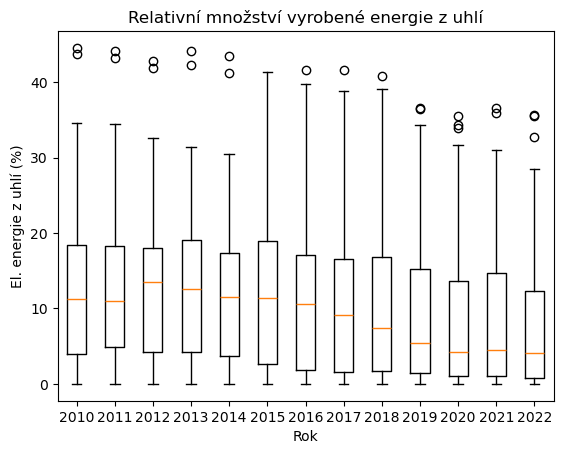

In [130]:
relative_energy_source_box('Coal',
                            title='Relativní množství vyrobené energie z uhlí',
                            ylabel='El. energie z uhlí (%)')

In [131]:
coal_bins = [-np.inf, .05, .1, .2, .3, np.inf]
coal_labels = ['very low or none', 'low', 'medium', 'high', 'very high']

df['coal'] = pd.cut(x=df['coal_perc'], bins=coal_bins, labels=coal_labels)
df.drop('coal_perc', axis='columns', inplace=True)

### `nuclear_perc`

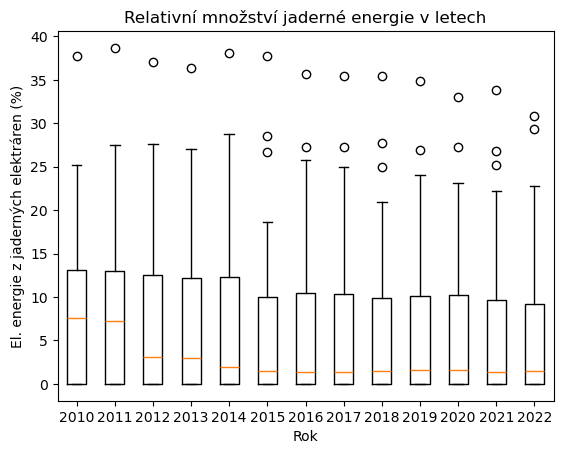

In [362]:
relative_energy_source_box('Nuclear',
                            title='Relativní množství jaderné energie v letech',
                            ylabel='El. energie z jaderných elektráren (%)')

In [133]:
nuclear_bins = [-np.inf, .02, .07, 0.1, 0.25, np.inf]
nuclear_labels = ['very low or none', 'low', 'medium', 'high', 'very high']

df['nuclear'] = pd.cut(x=df['nuclear_perc'], bins=nuclear_bins, labels=nuclear_labels)
df.drop('nuclear_perc', axis='columns', inplace=True)

### `hydro_perc`

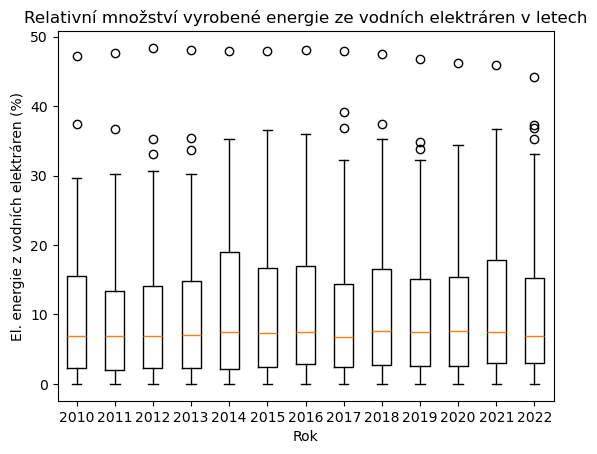

In [134]:
relative_energy_source_box('Hydro',
                            title='Relativní množství vyrobené energie ze vodních elektráren v letech',
                            ylabel='El. energie z vodních elektráren (%)')

In [135]:
hydro_bins = [-np.inf, .03, .07, 0.12, np.inf]
hydro_labels = ['very low or none', 'low', 'medium', 'high']

df['hydro'] = pd.cut(x=df['hydro_perc'], bins=hydro_bins, labels=hydro_labels)
df.drop('hydro_perc', axis='columns', inplace=True)

### `solar_perc`

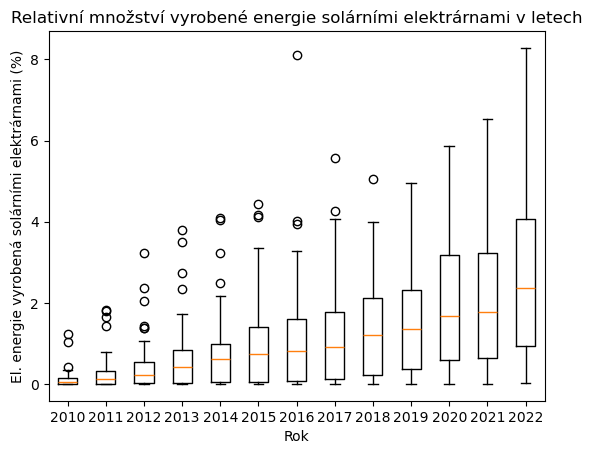

In [136]:
relative_energy_source_box('Solar',
                            title='Relativní množství vyrobené energie solárními elektrárnami v letech',
                            ylabel='El. energie vyrobená solárními elektrárnami (%)')

In [137]:
bins = [-np.inf, .002, .01, .02, .04, np.inf]
labels = ['very low or none', 'low', 'medium', 'high', 'very high']

df['solar'] = pd.cut(x=df['solar_perc'], bins=bins, labels=labels)
df.drop('solar_perc', axis='columns', inplace=True)

### `wind_perc`

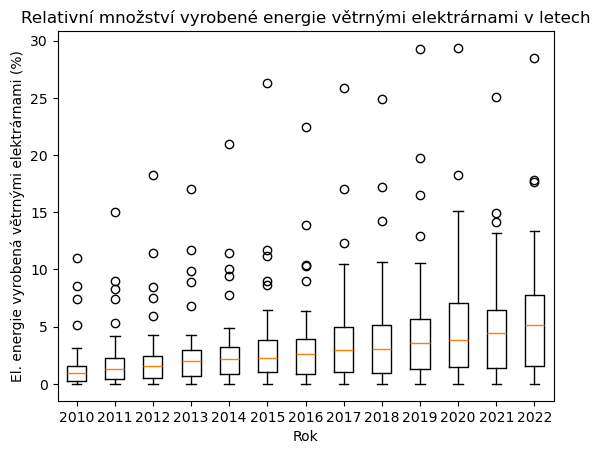

In [138]:
relative_energy_source_box('Wind',
                            title='Relativní množství vyrobené energie větrnými elektrárnami v letech',
                            ylabel='El. energie vyrobená větrnými elektrárnami (%)')

In [139]:
bins = [-np.inf, .01, .02, .2, .5, np.inf]
labels = ['very low or none', 'low', 'medium', 'high', 'very high']

df['wind'] = pd.cut(x=df['wind_perc'], bins=bins, labels=labels)
df.drop('wind_perc', axis='columns', inplace=True)

### `renewables_perc`

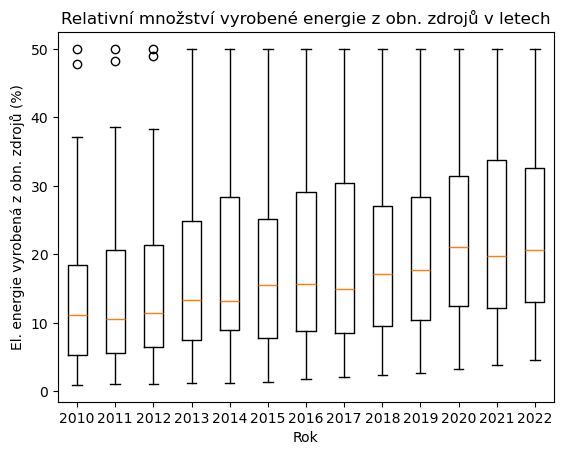

In [140]:
relative_energy_source_box(renewables,
                            title='Relativní množství vyrobené energie z obn. zdrojů v letech',
                            ylabel='El. energie vyrobená z obn. zdrojů (%)')

In [141]:
bins = [-np.inf, .07, .18, .25, .32, np.inf]
labels = ['very low or none', 'low', 'medium', 'high', 'very high']

df['renewables'] = pd.cut(x=df['renewables_perc'], bins=bins, labels=labels)
df.drop('renewables_perc', axis='columns', inplace=True)

### `temeratures`

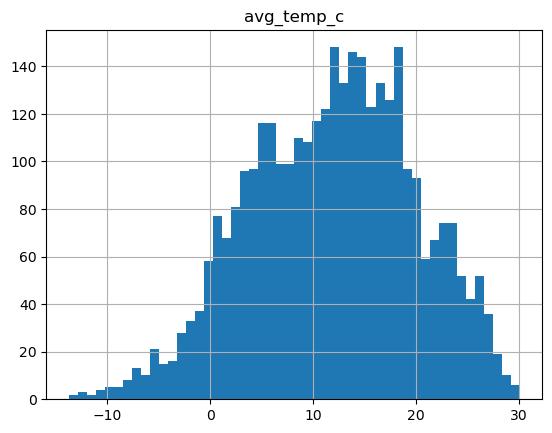

In [142]:
df.hist('avg_temp_c', bins=50)

bins = [-np.inf, 0, 10, 20, np.inf]
labels = ['very low', 'low', 'medium', 'high']

df['avg_temp'] = pd.cut(x=df['avg_temp_c'], bins=bins, labels=labels)
df.drop('avg_temp_c', axis='columns', inplace=True)

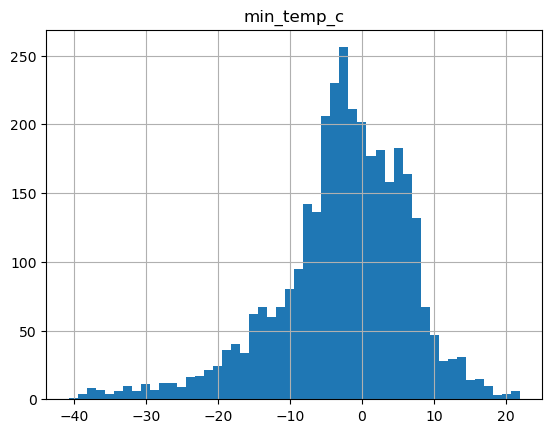

In [143]:
df.hist('min_temp_c', bins=50)

bins = [-np.inf, -15, -5, 5, 15, np.inf]
labels = ['very low', 'low', 'medium', 'high', 'very high']

df['min_temp'] = pd.cut(x=df['min_temp_c'], bins=bins, labels=labels)
df.drop('min_temp_c', axis='columns', inplace=True)

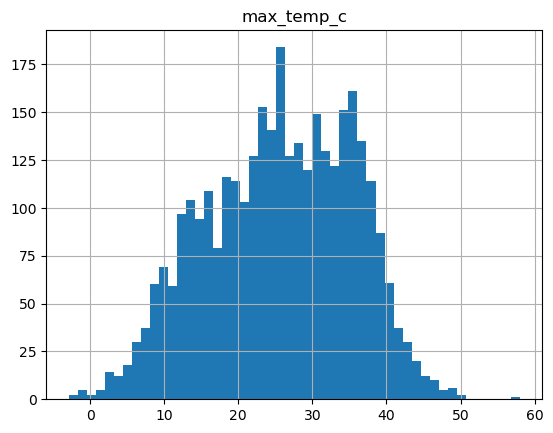

In [144]:
df.hist('max_temp_c', bins=50)

bins = [-np.inf, 15, 23, 33, 40, np.inf]
labels = ['very low', 'low', 'medium', 'high', 'very high']

df['max_temp'] = pd.cut(x=df['max_temp_c'], bins=bins, labels=labels)
df.drop('max_temp_c', axis='columns', inplace=True)

### `population_density`

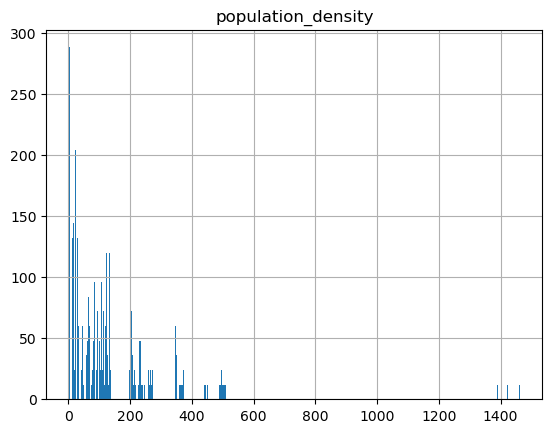

In [145]:
df.hist('population_density', bins=500)

bins = [-np.inf, 50, 100, 220, 400, np.inf]
labels = ['very low', 'low', 'medium', 'high', 'very high']

df['population_density'] = pd.cut(x=df['population_density'], bins=bins, labels=labels)

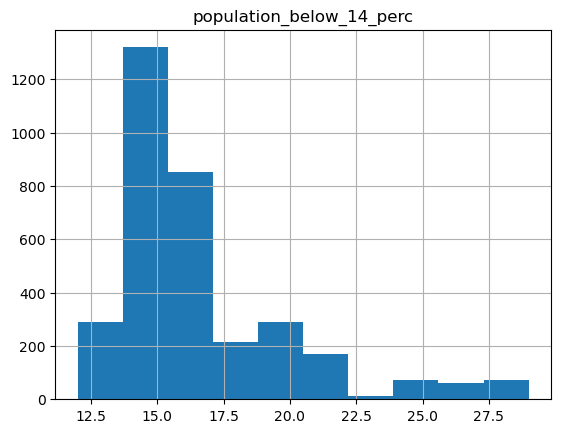

In [146]:
df.hist('population_below_14_perc', bins=10)

bins = [-np.inf, 13, 15, 17, 20, np.inf]
labels = ['very low', 'low', 'medium', 'high', 'very high']

df['population_below_14'] = pd.cut(x=df['population_below_14_perc'], bins=bins, labels=labels)
df.drop('population_below_14_perc', axis='columns', inplace=True)

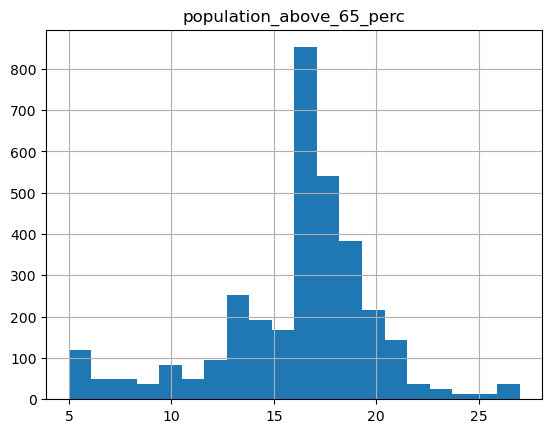

In [147]:
df.hist('population_above_65_perc', bins=20)

bins = [-np.inf, 7, 15, 18, np.inf]
labels = ['very low', 'low', 'medium', 'high']

df['population_above_65'] = pd.cut(x=df['population_above_65_perc'], bins=bins, labels=labels)
df.drop('population_above_65_perc', axis='columns', inplace=True)

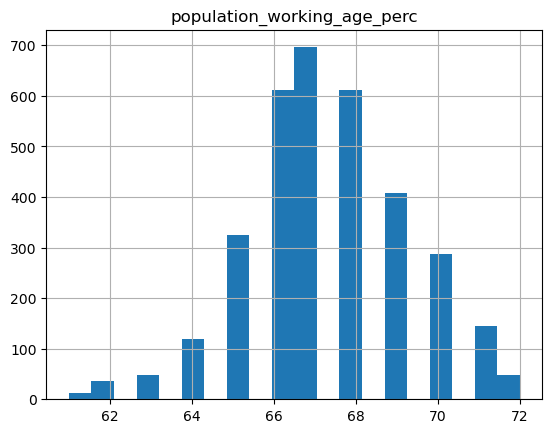

In [148]:
df.hist('population_working_age_perc', bins=20)

bins = [-np.inf, 65, 67, 69, 70, np.inf]
labels = ['very low', 'low', 'medium', 'high', 'very high']

df['population_working_age'] = pd.cut(x=df['population_working_age_perc'], bins=bins, labels=labels)
df.drop('population_working_age_perc', axis='columns', inplace=True)

### `weather`

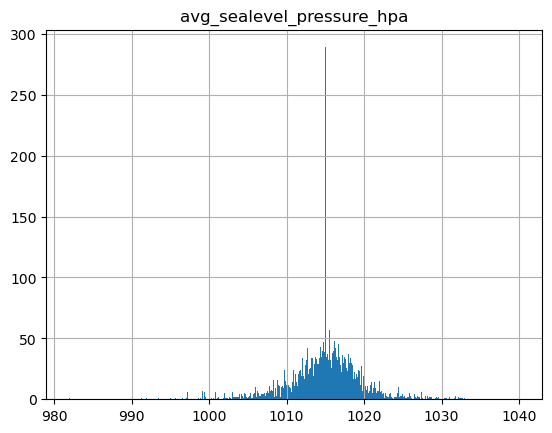

In [149]:
df.hist('avg_sealevel_pressure_hpa', bins=500)
bins = [-np.inf, 1010, 1015, 1020, np.inf]
labels = ['very low', 'low', 'medium', 'high']

df['avg_sealevel_pressure_hpa'] = pd.cut(x=df['avg_sealevel_pressure_hpa'], bins=bins, labels=labels)

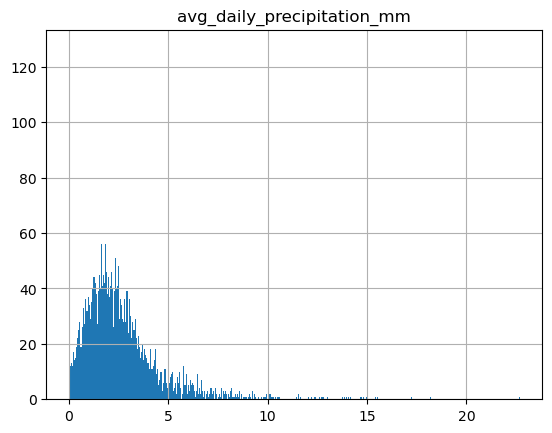

In [150]:
df.hist('avg_daily_precipitation_mm', bins=500)
bins = [-np.inf, 2, 5, np.inf]
labels = ['low', 'medium', 'high']

df['avg_daily_precipitation_mm'] = pd.cut(x=df['avg_daily_precipitation_mm'], bins=bins, labels=labels)

## Export dat

In [366]:
FILE_NAME = 'data_matrix.csv'

df.to_csv(f'data/{FILE_NAME}', sep=';')

In [152]:
df.columnsd

Index(['index', 'country', 'year', 'month', 'season',
       'avg_sealevel_pressure_hpa', 'avg_daily_precipitation_mm',
       'female_perc', 'male_perc', 'population_density', 'coal', 'nuclear',
       'hydro', 'solar', 'wind', 'renewables', 'avg_temp', 'min_temp',
       'max_temp', 'population_below_14', 'population_above_65',
       'population_working_age'],
      dtype='object')

In [368]:
df = pd.read_csv(f'data/{FILE_NAME}', sep=';')

# Grafy proměnných

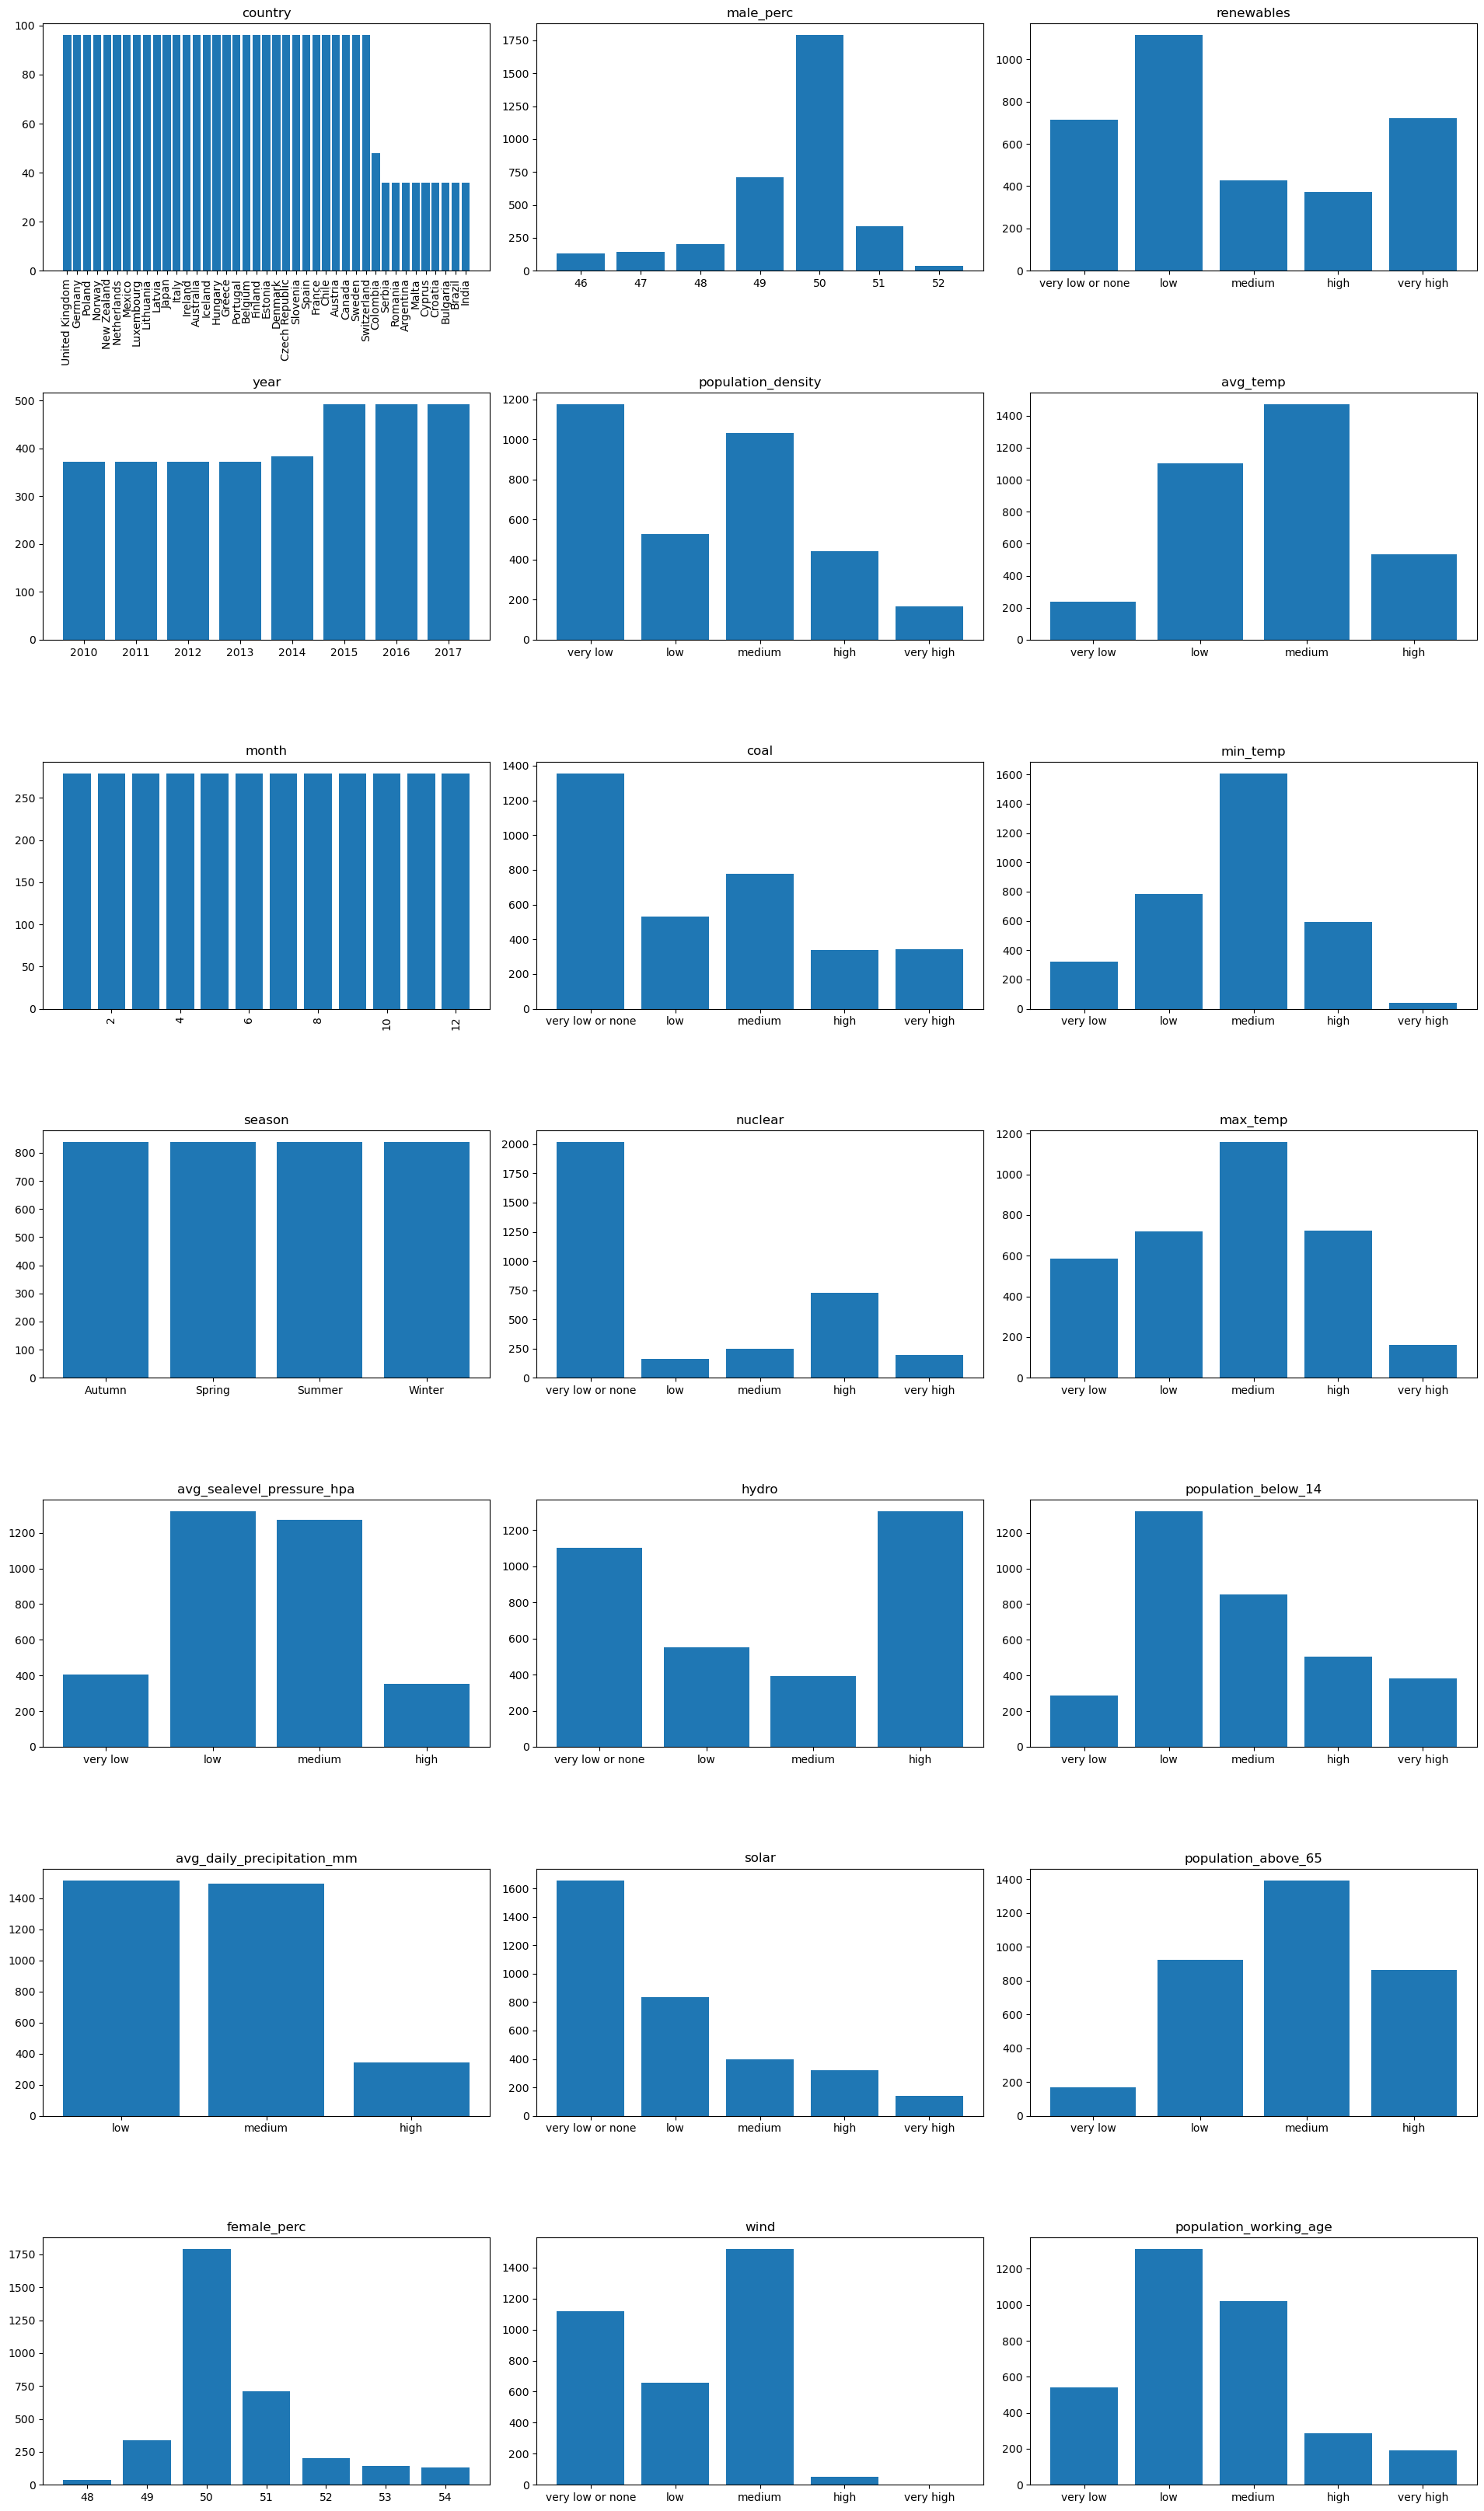

In [159]:
n_cols_in_graph = 3
n_cols = len(df.columns.values)
fig, axs = plt.subplots(ncols=n_cols_in_graph, nrows=math.ceil(n_cols / n_cols_in_graph))
fig.set_figwidth(19.2)
fig.set_figheight(32.4)
    
for i, col in enumerate(df.columns.values):
    coln = i // math.ceil(n_cols / n_cols_in_graph)
    rown = i % math.ceil(n_cols / n_cols_in_graph)

    ax = axs[rown, coln]
    values = df[col].sort_values().value_counts()
    
    if any([x in labels_sorted for x in values.index]):
        values = values.sort_index()
        
    ax.bar(values.index, values.values)
    ax.set_title(col)
    if len(values) > 10:
        ax.tick_params(axis='x', rotation=90)
    
plt.tight_layout()
plt.show(fig)
plt.close(fig)

# Dolování pravidel

In [154]:
class Literal:
    @staticmethod
    def subset(name: str, **kwargs):
        return { 'name': name, 'minlen': 1, 'maxlen': 1, 'type': 'subset', **kwargs, }

    @staticmethod
    def sequence(name: str, **kwargs):
        return { 'name': name, 'minlen': 1, 'maxlen': 1, 'type': 'seq', **kwargs, }

    @staticmethod
    def lcut(name: str, **kwargs):
        return { 'name': name, 'minlen': 1, 'maxlen': 1, 'type': 'lcut', **kwargs, }

    @staticmethod
    def rcut(name: str, **kwargs):
        return { 'name': name, 'minlen': 1, 'maxlen': 1, 'type': 'rcut', **kwargs, }

## Analytická otázka č. 1 (4ftMiner)
Předpokládáme, že lidé ve vyspělých zemích se dožívají vyšších let (v našich datech rostoucí _population_above_65_). Je pravda, že vyspělé země se zároveň vyznačují vyšším množstvím vyrobené energie z jaderných a solárních elektráren?

In [155]:
clm_01a = cleverminer(df=df,
                     proc='4ftMiner', 
                     quantifiers={'conf': 0.3, 'RelBase': 0.1},
                     ante={'attributes': [
                         Literal.subset('nuclear'),
                     ], 'minlen': 1, 'maxlen': 1, 'type': 'con' },
                     succ={'attributes': [
                         Literal.subset('population_above_65'),
                     ], 'minlen': 1, 'maxlen': 1, 'type': 'con' },
                    )

clm_01a.print_summary()
clm_01a.print_rulelist()

Cleverminer version 1.0.12.
Starting data preparation ...
Automatically reordering numeric categories ...
 If you haven't set maximum number of categories and you really need more categories and you know what you are doing, please use max_categories option to increase allowed number of categories.
Encoding columns into bit-form...
Encoding columns into bit-form...done
Data preparation finished.
Will go for  4ftMiner
Starting to mine rules.
100%|####################################################|Elapsed Time: 0:00:00
Done. Total verifications : 4, rules 2, times: prep 0.04sec, processing 0.01sec

CleverMiner task processing summary:

Task type : 4ftMiner
Number of verifications : 4
Number of rules : 2
Total time needed : 00h 00m 00s
Time of data preparation : 00h 00m 00s
Time of rule mining : 00h 00m 00s


List of rules:
RULEID BASE  CONF  AAD    Rule
     1   806 0.400 +0.449 nuclear(very low or none) => population_above_65(low) | ---
     2   497 0.686 +0.649 nuclear(high) => popula

### Závěr z jednoduchých pravidel
- První získané pravidlo potvrzuje logický opak otázky, tj. v zemích, kde je nízké procento obyvytel nad 65 let, se vyrábí relativně méně elektrické energie ze štěpení jádra.
- Druhé pravidlo mírně nahrává správnosti teorie v analytické otázce 1. O zemích, které vyrábějí relativně vysoké množství el. energie jadernými elektrárnami, můžeme řící, že mají relativně větší množství obyvytel s věkem nad 65 let.

In [156]:
clm_01b = cleverminer(df=df,
                     proc='4ftMiner', 
                     quantifiers={'conf': 0.9, 'RelBase': 0.25},
                     ante={'attributes': [
                         Literal.sequence('nuclear', maxlen=2),
                         Literal.subset('solar'),
                     ], 'minlen': 1, 'maxlen': 2, 'type': 'con' },
                     succ={'attributes': [
                         Literal.sequence('population_above_65', maxlen=2),
                     ], 'minlen': 1, 'maxlen': 1, 'type': 'con' },
                    )

clm_01b.print_summary()
clm_01b.print_rulelist()

Cleverminer version 1.0.12.
Starting data preparation ...
Automatically reordering numeric categories ...
Encoding columns into bit-form...
Encoding columns into bit-form...done
Data preparation finished.
Will go for  4ftMiner
Starting to mine rules.
100%|####################################################|Elapsed Time: 0:00:00
Done. Total verifications : 13, rules 2, times: prep 0.03sec, processing 0.01sec

CleverMiner task processing summary:

Task type : 4ftMiner
Number of verifications : 13
Number of rules : 2
Total time needed : 00h 00m 00s
Time of data preparation : 00h 00m 00s
Time of rule mining : 00h 00m 00s


List of rules:
RULEID BASE  CONF  AAD    Rule
     1   910 0.932 +0.384 nuclear(medium high) => population_above_65(medium high) | ---
     2   894 0.974 +0.445 nuclear(high very high) => population_above_65(medium high) | ---



### Závěr z rozšířeného dolování
- Pravidlo č. 2 potvrzuje hypotézu otázky - vyšší výroba energie jadernými elektrárnami ~ vyšší procento populace nad 65 let.

- Využili jsme sequence<1; 2> pro rozšíření záběru antecedentu (chceme hledat "high" a "very high" dohromady), a zároveň chceme, aby hodnoty byly za sebou jdoucí.

## Analytická otázka č. 2 (4ftMiner)
Existují sezónní zdroje energie?

In [157]:
energy_sources_attrs = [
    Literal.lcut('coal', maxlen=2),
    Literal.rcut('coal', maxlen=2),
    
    Literal.lcut('nuclear', maxlen=2),
    Literal.rcut('nuclear', maxlen=2),
    
    Literal.lcut('hydro', maxlen=2),
    Literal.rcut('hydro', maxlen=2),
    
    Literal.lcut('solar', maxlen=2),
    Literal.rcut('solar', maxlen=2),
    
    Literal.lcut('wind', maxlen=2),
    Literal.rcut('wind', maxlen=2),
]

clm_02 = cleverminer(df=df,
                     proc='4ftMiner', 
                     quantifiers={'conf': 0.75, 'RelBase': 0.1},
                     ante={'attributes': [
                         Literal.subset('season'),
                     ], 'minlen': 1, 'maxlen': 1, 'type': 'con' },
                     succ={'attributes': energy_sources_attrs, 
                           'minlen': 1, 
                           'maxlen': len(energy_sources_attrs), 
                           'type': 'con' },
                    )

clm_02.print_summary()
clm_02.print_rulelist()

Cleverminer version 1.0.12.
Starting data preparation ...
Automatically reordering numeric categories ...
Encoding columns into bit-form...
Encoding columns into bit-form...done
Data preparation finished.
Will go for  4ftMiner
Starting to mine rules.
100%|####################################################|Elapsed Time: 0:00:00
Done. Total verifications : 57, rules 2, times: prep 0.03sec, processing 0.02sec

CleverMiner task processing summary:

Task type : 4ftMiner
Number of verifications : 57
Number of rules : 2
Total time needed : 00h 00m 00s
Time of data preparation : 00h 00m 00s
Time of rule mining : 00h 00m 00s


List of rules:
RULEID BASE  CONF  AAD    Rule
     1   654 0.781 +0.051 season(Autumn) => solar(very low or none low) | ---
     2   741 0.885 +0.190 season(Winter) => solar(very low or none low) | ---



### Závěr pro otázku č.2
Jako sezonní zdroj energie jsme odhalili _solar_ - na podzim a v zimě dochází k výrobě nižšího množství el. energie solárními elektrárnami. K ověření tohoto závěru je možné vyzkoušet dolovat akční pravidla ke stejné tématice.

- Použili jsme dvojice `lcut<1; 2>` a `rcut<1; 2>` pro každý parametr v anteLiteralu - hledáme extrémní hodnoty v ročních obdobích.

## Analytická otázka č. 3 (CFMiner)
Hledejme země, ve kterých s postupem let roste počet měsíců v roce (alespoň 3 roky po sobě), ve kterých bylo vyrobeno relativně velké množství el. energie z obnovitelných zdrojů.

Cleverminer version 1.0.12.
Starting data preparation ...
Automatically reordering numeric categories ...
Encoding columns into bit-form...
Encoding columns into bit-form...done
Data preparation finished.
Will go for  CFMiner
Starting to mine rules.
100%|####################################################|Elapsed Time: 0:00:00
Done. Total verifications : 44, rules 4, times: prep 0.03sec, processing 0.02sec

CleverMiner task processing summary:

Task type : CFMiner
Number of verifications : 44
Number of rules : 4
Total time needed : 00h 00m 00s
Time of data preparation : 00h 00m 00s
Time of rule mining : 00h 00m 00s


List of rules:
RULEID BASE  S_UP  S_DOWN Condition
     1    78     3     1 country(Austria) & renewables(very high)
     2    63     3     1 country(Canada) & renewables(very high)
     3    47     4     2 country(Italy) & renewables(very high high medium)
     4    41     3     1 country(Switzerland) & renewables(very high)



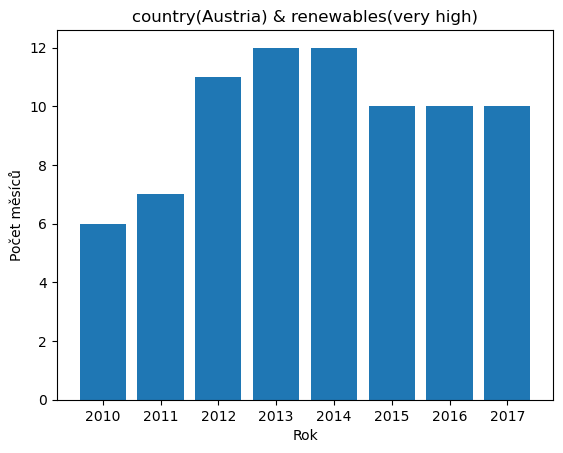

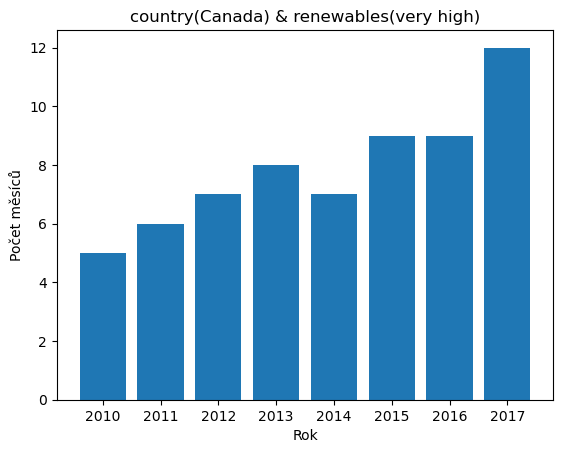

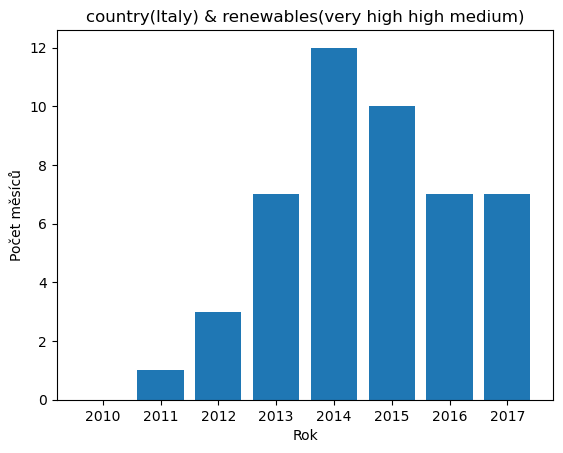

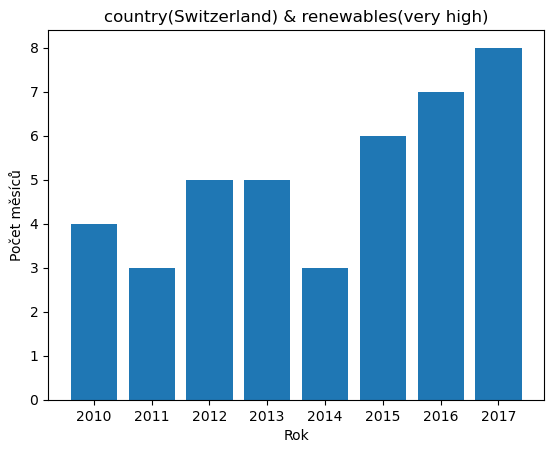

In [158]:
clm_03 = cleverminer(df=df,
                     target='year',
                     proc='CFMiner', 
                     quantifiers={'S_Up': 3, 'RelBase': 0.01},
                     cond={'attributes': [
                         Literal.subset('country'),
                         Literal.rcut('renewables', maxlen=3),
                     ], 'minlen': 2, 'maxlen': 2, 'type': 'con' })

clm_03.print_summary()
clm_03.print_rulelist()

for rule in clm_03.result['rules']:
    hist = rule['params']['hist']
    fig, ax = plt.subplots()
    h = ax.bar(sorted(list(df['year'].unique())), hist)
    ax.set_title(rule['cedents_str']['cond'])
    ax.set_xlabel('Rok')
    ax.set_ylabel('Počet měsíců')

### Závěr pro otázku č. 3
Našli jsme 4 země, ve kterých platí, že s postupem času roste počet měsíců v roce, ve kterých bylo vyrobeno velké množství el. energie z obn. zdrojů.

- V podmínce jsme použili `rcut<1; 3>`, jelikož chceme pouze sledovat hodnoty parametru `renewables("very high", "high", "medium")`.

## Analytická otázka č. 4 (CFMiner)
Existují nějaké trendy výroby el. energie z uhlí v různých měsících?

Cleverminer version 1.0.12.
Starting data preparation ...
Automatically reordering numeric categories ...
Encoding columns into bit-form...
Encoding columns into bit-form...done
Data preparation finished.
Will go for  CFMiner
Starting to mine rules.
100%|####################################################|Elapsed Time: 0:00:00
Done. Total verifications : 37, rules 4, times: prep 0.04sec, processing 0.02sec

CleverMiner task processing summary:

Task type : CFMiner
Number of verifications : 37
Number of rules : 4
Total time needed : 00h 00m 00s
Time of data preparation : 00h 00m 00s
Time of rule mining : 00h 00m 00s


List of rules:
RULEID BASE  S_UP  S_DOWN Condition
     1    63     3     2 country(Austria) & coal(very low or none)
     2    54     3     2 country(Finland) & coal(low)
     3    67     3     2 country(Hungary) & coal(low)
     4    63     3     1 country(Portugal) & coal(medium)



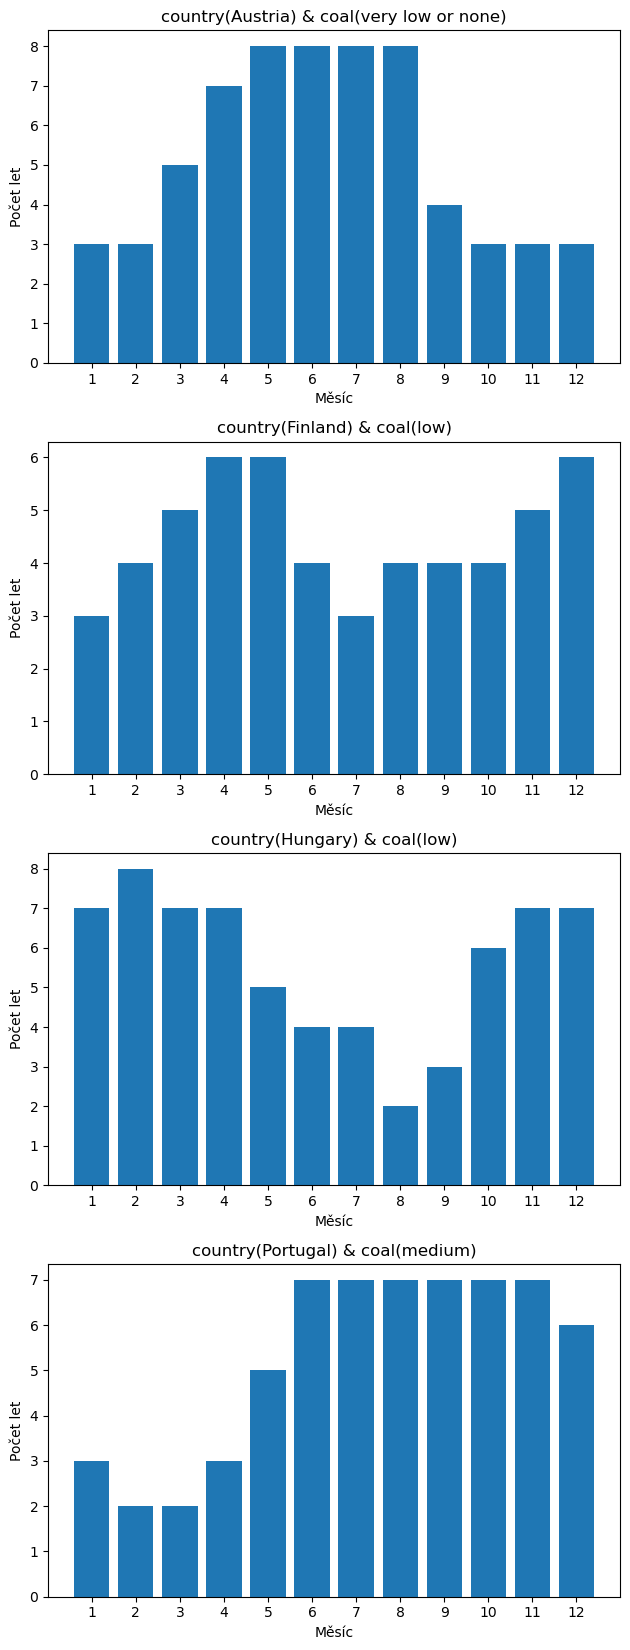

In [240]:
clm_04 = cleverminer(df=df,
                     target='month',
                     proc='CFMiner', 
                     quantifiers={'S_Up': 3, 'RelBase': 0.01},
                     cond={'attributes': [
                         Literal.subset('country'),
                         Literal.subset('coal'),
                     ], 'minlen': 2, 'maxlen': 2, 'type': 'con' })

clm_04.print_summary()
clm_04.print_rulelist()

fig, axs = plt.subplots(nrows=len(clm_04.result['rules']))
fig.set_figheight(16.6)

for i, rule in enumerate(clm_04.result['rules']):
    hist = rule['params']['hist']
    month_names = range(1, len(hist) + 1)
    ax = axs[i]
    h = ax.bar(month_names, hist)
    ax.set_title(rule['cedents_str']['cond'])
    ax.set_xlabel('Měsíc')
    ax.set_xticks(month_names)
    ax.set_ylabel('Počet let')

plt.tight_layout()
plt.show(fig)
plt.close(fig)

### Závěr pro otázku č. 4
- Je vidět, že v Rakousku roste počet měsíců, ve kterých je nízké procento el. energie vyrobeno uhelnými elektrárnami, čím blíže je léto. Následně počet klesá. To znamená, se uhelné elektrárny podílí na výrobě elektřiny v zimě více, než v létě.
- Doporučením by mohlo být investování do obnovitelných zdrojů, které nejsou sezónní.

## Analytická otázka č. 5 (SD4ftMiner)
Existují země, ve kterých dochází při změně průměrné teploty zároveň ke změně relativního množství vyrobené energie z obnovitelných zdrojů?

In [243]:
clm_05 = cleverminer(df=df,
                     proc='SD4ftMiner',
                     quantifiers={'Frstconf': 0.1, 'FrstRelBase': 0.01, 'ScndRelBase': 0.01, 'RatioConf' : 1.15},
                     ante={'attributes': [
                         Literal.subset('country'),
                     ], 'minlen':1, 'maxlen':1, 'type':'con'},
                     succ={'attributes': [
                        Literal.sequence('renewables', maxlen=2),
                     ], 'minlen':1, 'maxlen':1, 'type':'con'},
                     frst={'attributes': [
                        Literal.subset('avg_temp'),
                     ], 'minlen':1, 'maxlen':1, 'type':'con'},
                     scnd={'attributes': [
                        Literal.subset('avg_temp'),
                     ], 'minlen':1, 'maxlen':1, 'type':'con'})

clm_05.print_summary()
clm_05.print_rulelist()
clm_05.print_rule(1)

Cleverminer version 1.0.12.
Starting data preparation ...
Automatically reordering numeric categories ...
Encoding columns into bit-form...
Encoding columns into bit-form...done
Data preparation finished.
Will go for  SD4ftMiner
Starting to mine rules.
100%|####################################################|Elapsed Time: 0:00:0000
Done. Total verifications : 1712, rules 1, times: prep 0.06sec, processing 0.13sec

CleverMiner task processing summary:

Task type : SD4ftMiner
Number of verifications : 1712
Number of rules : 1
Total time needed : 00h 00m 00s
Time of data preparation : 00h 00m 00s
Time of rule mining : 00h 00m 00s


List of rules:
RULEID BASE1 BASE2 RatioConf DeltaConf Rule
     1    45    42    1.165    +0.138  country(Ireland) => renewables(very low or none low) | --- : avg_temp(medium) x avg_temp(low)



Rule id : 1

Base1 :    45 Base2 :    42  Relative base 1 : 0.013 Relative base 2 : 0.013 CONF1 : 0.978  CONF2 : +0.840  Delta Conf : +0.138 Ratio Conf : +1.165

Ceden

### Závěr k otázce č. 5
V Irsku je poměr vyrobené energie z obnovitelných zdrojů závislý na průměrné teplotě. Můžeme říct, že v měsících, kdy je nízká průměrná templota, je pravděpodobnější, že bude relativně nižší množství energie vyrobené z obn. zdrojů.

- Pokud by Irsko chtělo zvyšovat podíl obn. zdrojů, tak by se mělo zaměřit na zdroje, které nejsou závislé na teplotě.

## Analytická otázka č. 6 (SD4ftMiner)
Existují zdroje energie, které jsou v některých obdobích závislejší na extrémy v atmosferickém tlaku?

In [260]:
clm_06 = cleverminer(df=df,
                     proc='SD4ftMiner',
                     quantifiers={'Frstconf': 0.5, 'FrstRelBase': 0.03, 'ScndRelBase': 0.01, 'RatioConf' : 1.5},
                     ante={'attributes': [
                         Literal.lcut('avg_sealevel_pressure_hpa'),
                         Literal.rcut('avg_sealevel_pressure_hpa'),
                     ], 'minlen':1, 'maxlen':1, 'type':'con'},
                     succ={'attributes': [
                         Literal.subset('renewables'),
                         Literal.subset('hydro'),
                         Literal.subset('coal'),
                         Literal.subset('nuclear'),
                         Literal.subset('solar'),
                         Literal.subset('wind'),
                     ], 'minlen':1, 'maxlen':1, 'type':'con'},
                     frst={'attributes': [
                        Literal.sequence('month', minlen=3, maxlen=6),
                     ], 'minlen':1, 'maxlen':1, 'type':'con'},
                     scnd={'attributes': [
                        Literal.sequence('month', minlen=3, maxlen=6),
                     ], 'minlen':1, 'maxlen':1, 'type':'con'})

clm_06.print_summary()
clm_06.print_rulelist()
clm_06.print_rule(1)

Cleverminer version 1.0.12.
Starting data preparation ...
Automatically reordering numeric categories ...
Encoding columns into bit-form...
Encoding columns into bit-form...done
Data preparation finished.
Will go for  SD4ftMiner
Starting to mine rules.
100%|####################################################|Elapsed Time: 0:00:0555
Done. Total verifications : 122472, rules 4, times: prep 0.04sec, processing 5.95sec

CleverMiner task processing summary:

Task type : SD4ftMiner
Number of verifications : 122472
Number of rules : 4
Total time needed : 00h 00m 05s
Time of data preparation : 00h 00m 00s
Time of rule mining : 00h 00m 05s


List of rules:
RULEID BASE1 BASE2 RatioConf DeltaConf Rule
     1   117    44    1.564    +0.310  avg_sealevel_pressure_hpa(very low) => solar(very low or none) | --- : month(9 10 11 12) x month(4 5 6)
     2   117    69    1.534    +0.299  avg_sealevel_pressure_hpa(very low) => solar(very low or none) | --- : month(9 10 11 12) x month(4 5 6 7)
     3   11

### Závěr pro otázku č. 6
V kombinaci s atmosferckým tlakem, existuje závislost výroby el. energie ze solárních elektráren také z ročního období. Můžeme to vysvělit zvýšeným počtem dní, ve kterých je zataženo.

- Je třeba počítat s vývyvy výroby el. energie ze solárních panelů a jejich sezónností.

## Analytická otázka č. 7
Jaké vlastnosti nejlépe charakterizují vysoké hodnoty `renewables`?

accuracy=0.8626865671641791


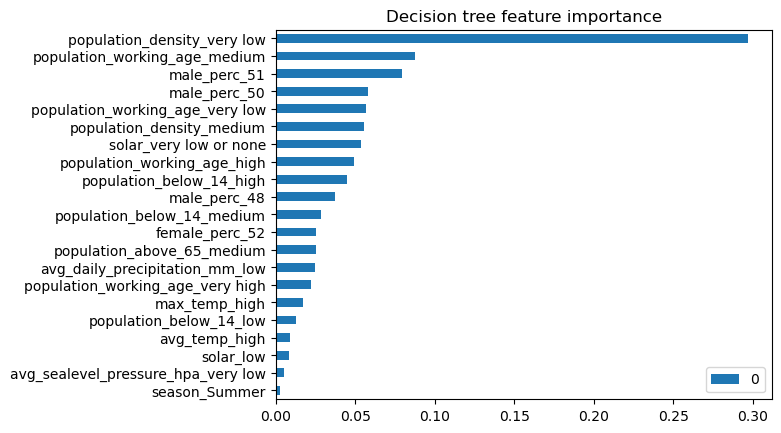

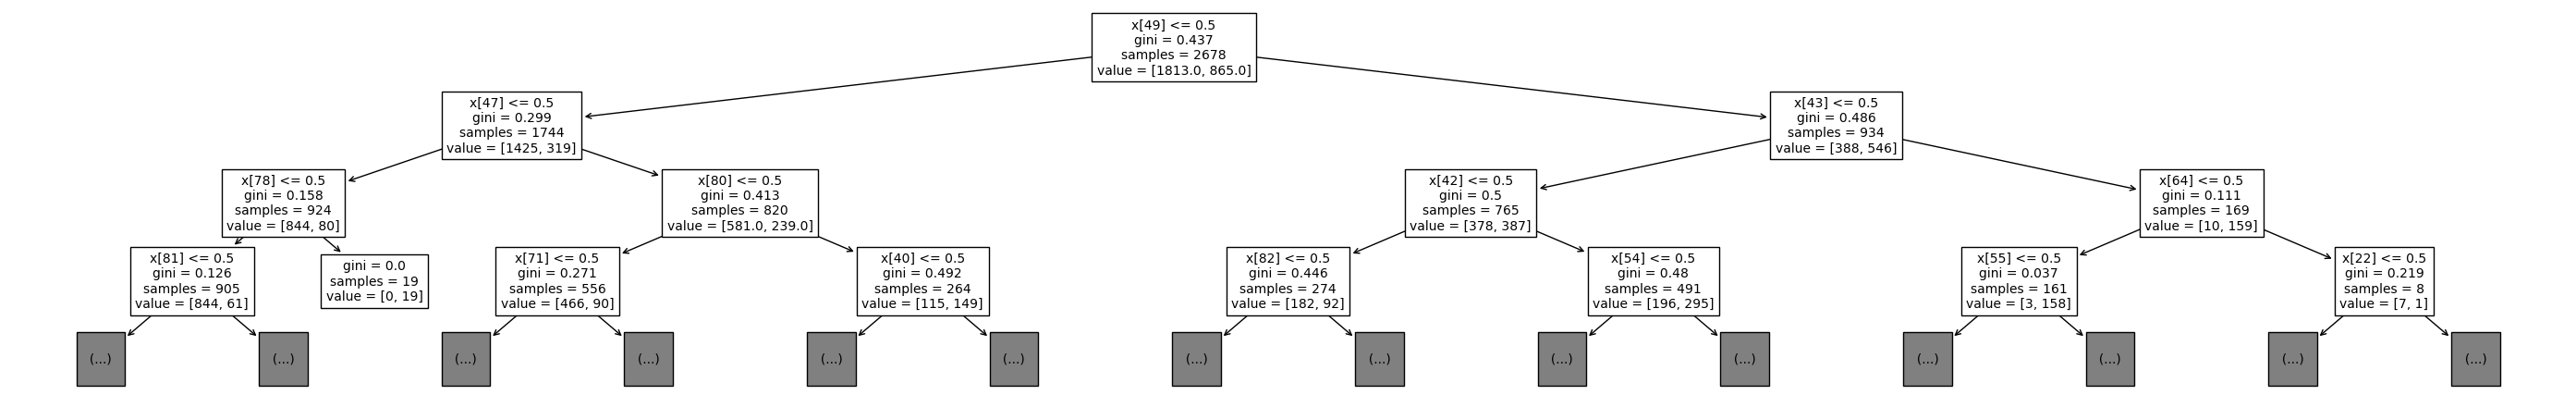

In [356]:
# Vysoké hodnoty = 'high' | 'very high'
df['renewables_high'] = (df['renewables'] == 'very high') | (df['renewables'] == 'high')
target_variable = df['renewables_high']

# Nechceme charakterizovat podle dílčích zdrojů energie nebo země
features_raw = df.drop(columns=['hydro', 'wind', 'coal', 'nuclear', 'renewables', 'renewables_high', 'country'])

# Transformace z kategoriálních do binárních dat
encoder = OneHotEncoder(sparse_output=False)
features = encoder.fit_transform(features_raw)

X_train, X_test, y_train, y_test = train_test_split(features, target_variable, test_size=0.2, random_state=42)
tree = DecisionTreeClassifier(max_depth=5)

tree.fit(X_train, y_train)
y_pred = tree.predict(X_test)

accuracy = tree.score(X_test, y_test)
print(f'{accuracy=}')

importances = pd.DataFrame(tree.feature_importances_)
importances.index = encoder.get_feature_names_out()
importances = importances[importances.iloc[:, 0] > 0].sort_values(by=0)
importances.plot(kind='barh', title='Decision tree feature importance')

fig, ax = plt.subplots()
fig.set_figwidth(28.4)
plt.tight_layout()
plot_tree(tree, ax=ax, fontsize=10, max_depth=3)

plt.show(fig)
plt.close(fig)